# **Strawberry Diseases Classification**

In this project we implements system of **strawberry diseases classification.** We build Android application which allow users to classify strawberry plant leaves diseases by selecting image from pictures library or right from the camera. We alse build website which allow users to upload image of plant leaves strawberry and get the right classification.

First, we prepare the dataset and builds the model by using transfer learning technique on different models like **VGG16, VGG19** and **ResNet50**. We compere the models performance and choose the optimial model for our project. We work with Google Colab and use **Tensorflow** with **Keras** in **Python**. We also use libraries like **numpy, matplotlib, os, json** etc.

We classify the images to 7 types of category:

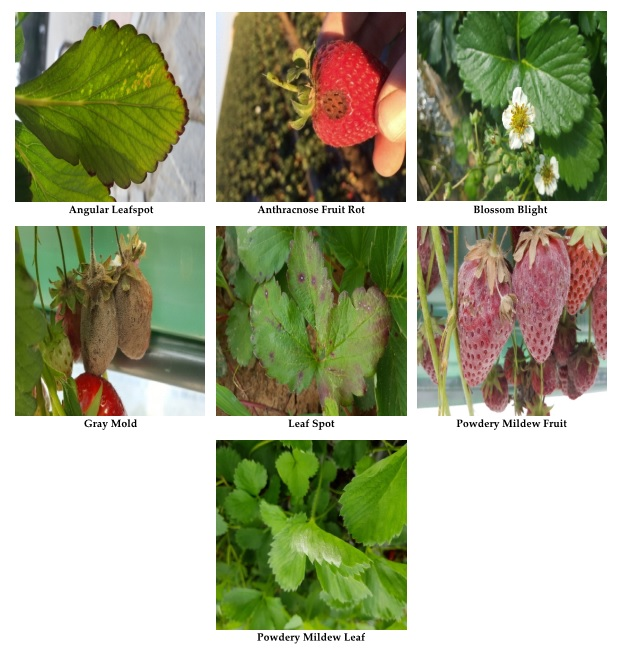

## **1. Import libraires**

#### Import laberies

In [ ]:
import os
import cv2
import json
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.applications import ResNet50
from pandas.io.json import json_normalize
from keras.callbacks import EarlyStopping
from keras.optimizers import Adadelta, Adam
from keras.layers import BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

In [ ]:
labels_name = ["Angular Leafspot", "Anthracnose Fruit Rot", "Blossom Blight",
               "Gray Mold", "Leaf Spot", "Powdery Mildew Fruit", "Powdery Mildew Leaf"]

## **2. Create Dataset**


### **Create dataset**

#### Extract the train dataset

In [ ]:
import os

images = []
labels = []
images_paths = []
labels_paths = []

filesnames = os.listdir('/content/drive/MyDrive/Dataset/Strawberries/train')
filesnames.sort()

for filename in filesnames:

  end = filename.split('.')[1]

  # Extract the images from the paths
  if end == 'jpg':
    path = os.path.join('/content/drive/MyDrive/Dataset/Strawberries/train', filename)
    image = load_img(path)
    image = img_to_array(image)
    image = image.astype('float32')
    # image = image / 255
    image = cv2.resize(image, (224, 224))
    images.append(image)

  # Extract the labels from the paths
  if end == 'json':
    json_path = os.path.join('/content/drive/MyDrive/Dataset/Strawberries/train', filename)
    json_file = json.load(open(json_path))
    shapes = json_file["shapes"]
    label = shapes[0]['label']

    # label_array = np.zeros(10, 'uint8')
    label_index = labels_name.index(label)
    # label_array[label_index] = 1
    labels.append(label_index)

# Create calidation dataset
x_train = np.array(images)
y_train = np.array(labels)

In [ ]:
len(images), len(labels)

(1454, 1454)

In [ ]:
x_train.shape

(1454, 224, 224, 3)

In [ ]:
y_train.shape

(1454,)

In [ ]:
y_train

array([0, 0, 0, ..., 6, 6, 6])

#### Extract the validation dataset

In [ ]:
import os

images = []
labels = []
images_paths = []
labels_paths = []

filesnames = os.listdir('/content/drive/MyDrive/Dataset/Strawberries/val')
filesnames.sort()

for filename in filesnames:

  end = filename.split('.')[1]

  # Extract the images from the paths
  if end == 'jpg':
    path = os.path.join('/content/drive/MyDrive/Dataset/Strawberries/val', filename)
    image = load_img(path)
    image = img_to_array(image)
    image = image.astype('float32')
    # image = image / 255
    image = cv2.resize(image, (224, 224))
    images.append(image)

  # Extract the labels from the paths
  if end == 'json':
    json_path = os.path.join('/content/drive/MyDrive/Dataset/Strawberries/val', filename)
    json_file = json.load(open(json_path))
    shapes = json_file["shapes"]
    label = shapes[0]['label']

    # label_array = np.zeros(10, 'uint8')
    label_index = labels_name.index(label)
    # label_array[label_index] = 1
    labels.append(label_index)

# Create calidation dataset
x_val = np.array(images)
y_val = np.array(labels)

In [ ]:
len(x_val), len(y_val)

(307, 307)

In [ ]:
x_val.shape

(307, 224, 224, 3)

In [ ]:
y_val.shape

(307,)

#### Extract the test dataset

In [ ]:
images = []
labels = []
images_paths = []
labels_paths = []

filesnames = os.listdir('/content/drive/MyDrive/Dataset/Strawberries/test')
filesnames.sort()

for filename in filesnames:

  end = filename.split('.')[1]

  # Extract the images from the paths
  if end == 'jpg':
    path = os.path.join('/content/drive/MyDrive/Dataset/Strawberries/test', filename)
    image = load_img(path)
    image = img_to_array(image)
    image = image.astype('float32')
    # image = image / 255
    image = cv2.resize(image, (224, 224))
    images.append(image)

  # Extract the labels from the paths
  if end == 'json':
    json_path = os.path.join('/content/drive/MyDrive/Dataset/Strawberries/test', filename)
    json_file = json.load(open(json_path))
    shapes = json_file["shapes"]
    label = shapes[0]['label']

    # label_array = np.zeros(10, 'uint8')
    label_index = labels_name.index(label)
    # label_array[label_index] = 1
    labels.append(label_index)

# Create calidation dataset
x_test = np.copy(images)
y_test = np.copy(labels)

x_test = np.array(x_test)
y_test = np.array(y_test)

In [ ]:
len(x_test), len(y_test)

(743, 743)

In [ ]:
x_train.shape

(1454, 224, 224, 3)

In [ ]:
# x_val.shape

In [ ]:
x_test.shape

(743, 224, 224, 3)

In [ ]:
y_train.shape

(1454,)

In [ ]:
y_test.shape

(743,)

In [ ]:
# y_val.shape

In [ ]:
y_test[0]

0

In [ ]:
# y_val[0]

In [ ]:
len(x_train)

1454

#### preprocess the data

In [ ]:
x_train = np.concatenate((x_train, x_val))
y_train = np.concatenate((y_train, y_val))

In [ ]:
# Import the one hot encode function
from tensorflow.keras.utils import to_categorical

# Store the number of images rows and columns
img_rows = x_train[0].shape[0]
img_cols = x_train[0].shape[1]

# Store the shape of single image
input_shape = (img_rows, img_cols, 3)
print("input_shape: ", input_shape)

# Getting our data in the right 'shape' needed for Keras
# We need to add the 4th dimension to our data thereby changing our
# Original image shape of (60000, 28, 28) to (60000, 28, 28, 1)
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)

num_of_classes = 7
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print("\nResizing images..")
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

input_shape:  (224, 224, 3)

Resizing images..
x_train shape: (1761, 224, 224, 3)
y_train shape: (1761, 7)
x_test shape: (743, 224, 224, 3)
y_test shape: (743, 7)


#### Display banch of images from dataset

In [ ]:
num_of_images = 20
figure = plt.figure(figsize=(18,14))

for index in range(0, num_of_images):

  i = random.randint(0, 419)

  image = x_test[i]
  image = image / 255
  img = image.reshape(1, 224, 224, 3)
  label = labels_name[np.argmax(y_test[i])]
  # prediction = labels_name[np.argmax(model.predict(img, verbose=0))]

  plt.subplot(4, 5, index +1).set_title(f"Label: {label}")
  plt.axis('off')
  plt.imshow(image)

Output hidden; open in https://colab.research.google.com to view.

## **3. Buil the model**

#### Building model

In [ ]:
from keras.callbacks import EarlyStopping
from keras.optimizers import Adadelta, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import SGD

input_shape = (224, 224, 3)

model = Sequential()

model.add(Conv2D(64, (3,3), activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3,3), activation='relu', input_shape=input_shape))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3,3), activation='relu', input_shape=input_shape))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
# model.add(Dense(128, 'relu'))
model.add(Dense(4096, 'relu'))
model.add(Dense(7, 'softmax'))
# model.compile(loss = 'categorical_crossentropy', optimizer = SGD(0.001), metrics = ['accuracy'])


model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

es = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=2,
                   verbose=1,
                   mode='auto')

# We can use the summary function to display our model layers and parameters
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 64)     256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 222, 222, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      36928     
                                                                 
 dropout_1 (Dropout)         (None, 109, 109, 64)      0

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

epochs = 30
batch_size = 32

# Define Data Generator for Augmentation
train_datagen = ImageDataGenerator( rotation_range=20,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    zoom_range=0.1,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

# Notice we use train_datagen.flow, this takes data & label arrays, generates batches of augmented data.
history = model.fit(train_datagen.flow(x_train, y_train, batch_size = batch_size),
                                        epochs = epochs,
                                        #callbacks = [es],
                                        validation_data = (x_test, y_test),
                                        verbose = 1,
                                        steps_per_epoch = x_train.shape[0] // batch_size)


# # # Store our results here so we can plot later
# history = model.fit(x_train, y_train,
#                     batch_size = batch_size,
#                     epochs = epochs,
#                     verbose = 1,
#                     #callbacks = [es],
#                     validation_data = (x_test, y_test))

# We obtain our accuracy score using the evalute function
# Score holds two values, our Test loss and Accuracy
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

### Building model using transfer learning

#### VGG19

In [ ]:
from keras.applications import VGG19
from keras.applications import VGG16

# Load VGG19 model without the top and define input shape to (224 X 224 X 3)
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224,224,3))

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

In [ ]:
len(base_model.layers)

22

In [ ]:
from keras.layers import GlobalAveragePooling2D

for layer in base_model.layers[:11]:
  layer.trainable = False

# base_model.trainable = False

head_model = base_model.output
head_model = GlobalAveragePooling2D()(head_model)
head_model = Dense(units=260, activation='relu')(head_model)
head_model = BatchNormalization()(head_model)
head_model = Dropout(rate=0.5)(head_model)
head_model = Dense(units=134, activation='relu')(head_model)
head_model = Dense(num_of_classes, 'softmax')(head_model)

model = Model(base_model.input, head_model)

model.summary()


# Define the optimizer, loss and merics of our model
metrics = ['accuracy']
loss = 'categorical_crossentropy'
optimizer = Adam(learning_rate=1e-5)
# optimizer = Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)


es = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=2,
                   verbose=1,
                   mode='auto')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

#### VGG16

In [ ]:
from keras.applications import VGG16

# Load VGG16 model without the top and define input shape to (224 X 224 X 3)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

In [ ]:
len(base_model.layers)

19

In [ ]:
from keras.layers import GlobalAveragePooling2D

# Create ResNet50 model as type Sequential
last_layer = base_model.get_layer('block5_pool')
output = last_layer.output
input = base_model.input
vgg_model = Model(input, output)

# Freezing the train layers in the model
for layer in vgg_model.layers:
  layer.trainable = False

# Print the model summary and type
# vgg_model.summary()

# Create Sequential type model
model = Sequential()

# Add the VGG16 base model to into it
model.add(vgg_model)

# Build the last layers on the base model and fit it to our dataset
model.add(GlobalAveragePooling2D())
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_of_classes, 'softmax'))

# Define the optimizer, loss and merics of our model
metrics = ['accuracy']
optimizer = Adam(0.0001)
loss_function = 'categorical_crossentropy'
model.compile(loss = loss_function, optimizer = optimizer, metrics = metrics)

# Define the Early Stopping opbject
es = EarlyStopping(monitor='val_loss', min_delta=0,
                   patience=2, verbose=1, mode='auto')

# Print the model type and summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_2 (Functional)        (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_4 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_10 (Dense)            (None, 256)               131328    
                                                                 
 dense_11 (Dense)            (None, 128)               32896     
                                                                 
 dropout_6 (Dropout)         (None, 128)              

#### ResNet50

In [ ]:
# Load ResNet50 model without the top and define input shape to (224 X 224 X 3)
ResNet50_base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Print the model summary
ResNet50_base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
from keras.layers import GlobalAveragePooling2D

base_model = ResNet50_base_model

head_model = base_model.output
head_model = GlobalAveragePooling2D()(head_model)
head_model = Dense(units = 1025, activation='relu')(head_model)
head_model = Dropout(rate = 0.5)(head_model)
head_model = Dense(units = 516, activation='relu')(head_model)
head_model = Dropout(rate = 0.5)(head_model)
head_model = Dense(num_of_classes, activation='softmax')(head_model)

model = Model(inputs = base_model.input, outputs = head_model)

fine_tuning_at = 140

for layer in base_model.layers[:fine_tuning_at]:
  layer.trainable = False

# Define the Early Stopping opbject
es = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=2,
                   verbose=1,
                   mode='auto')

# Define the optimizer, loss and merics of our model
metrics = ['accuracy']
optimizer = Adam(learning_rate=1e-5)
loss_function = 'categorical_crossentropy'

# Compile the model
model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)

# Display the model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

##### Another version of the ResNet50 model

In [ ]:
from keras.layers import GlobalAveragePooling2D

"Bulding model for feature extraction"


# Create ResNet50 model as type Sequential
last_layer = ResNet50_base_model.get_layer('conv5_block3_out')
last_layer_output = last_layer.output
first_layer_input = ResNet50_base_model.input
ResNet50_model_fnc = tf.keras.Model(first_layer_input, last_layer_output)

# Freezing the train layers in the model
for layer in ResNet50_model_fnc.layers:
   layer.trainable = False

# Print the model summary and type
print(type(ResNet50_model_fnc))
ResNet50_model_fnc.summary()

# Create Sequential type model
model = Sequential()

# Add the ResNet50 base model into it
model.add(ResNet50_model_fnc)

# Build the model input
model.build(input_shape)

# Flatten the last layer of the base model output
model.add(Flatten())

# Build the last layers on the base model and fit it to our dataset
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_of_classes, 'softmax'))

# Print the model type and summary
model.summary()

<class 'keras.engine.functional.Functional'>
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                               

In [ ]:
"Next line for Fine Tuning case"
# Make the model trainable
model.trainable = True

# Define the Early Stopping opbject
es = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=2,
                   verbose=1,
                   mode='auto')

# Define the optimizer, loss and merics of our model
metrics = ['accuracy']
optimizer = Adam(learning_rate=1e-5)
loss_function = 'categorical_crossentropy'

# Compile the model
model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)

# Display the model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_4 (Functional)        (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_16 (Dense)            (None, 256)               25690368  
                                                                 
 batch_normalization_7 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_17 (Dense)            (None, 256)               65792     
                                                      

## **4. Training Model**

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

epochs = 20
batch_size = 64
# model.trainable = True

# Define Data Generator for Augmentation
train_datagen = ImageDataGenerator( rotation_range=20,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    zoom_range=0.1,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

# Notice we use train_datagen.flow, this takes data & label arrays, generates batches of augmented data.
history = model.fit(train_datagen.flow(x_train, y_train, batch_size = batch_size),
                                        epochs = epochs,
                                        #callbacks = [es],
                                        validation_data = (x_test, y_test),
                                        verbose = 1,
                                        steps_per_epoch = x_train.shape[0] // batch_size)


"Next code for training without dara augmentation"
# Store our results here so we can plot later
# history = model.fit(x_train, y_train,
#                     batch_size = batch_size,
#                     epochs = epochs,
#                     callbacks = [es],
#                     verbose = 1,
#                     validation_data = (x_test, y_test))

# We obtain our accuracy score using the evalute function
# Score holds two values, our Test loss and Accuracy
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/20
27/27 [==============================] - 45s 1s/step - loss: 2.1405 - accuracy: 0.2416 - val_loss: 1.6936 - val_accuracy: 0.3701
Epoch 2/20
27/27 [==============================] - 22s 823ms/step - loss: 1.5989 - accuracy: 0.4272 - val_loss: 1.2995 - val_accuracy: 0.5707
Epoch 3/20
27/27 [==============================] - 24s 880ms/step - loss: 1.2348 - accuracy: 0.5810 - val_loss: 1.0218 - val_accuracy: 0.6864
Epoch 4/20
27/27 [==============================] - 23s 842ms/step - loss: 0.9896 - accuracy: 0.6883 - val_loss: 0.8290 - val_accuracy: 0.7537
Epoch 5/20
27/27 [==============================] - 23s 858ms/step - loss: 0.8233 - accuracy: 0.7566 - val_loss: 0.7042 - val_accuracy: 0.7847
Epoch 6/20
27/27 [==============================] - 22s 825ms/step - loss: 0.6875 - accuracy: 0.7932 - val_loss: 0.6169 - val_accuracy: 0.8102
Epoch 7/20
27/27 [==============================] - 23s 868ms/step - loss: 0.5789 - accuracy: 0.8209 - val_loss: 0.5572 - val_accuracy: 0.8183
Ep

## **5. Model performance analysis**

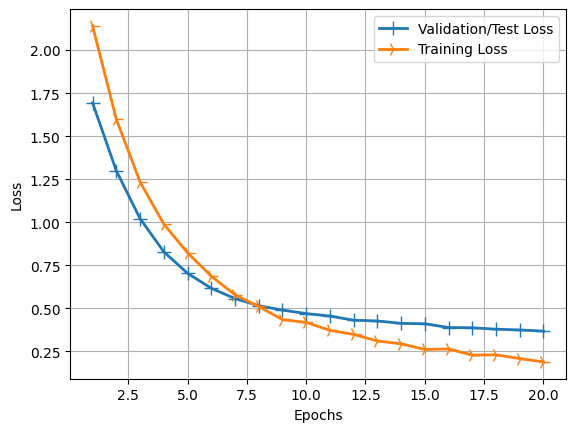

In [ ]:
# Plotting our loss charts
import matplotlib.pyplot as plt

# Use the History object we created to get our saved performance results
history_dict = history.history

# Extract the loss and validation losses
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

# Get the number of epochs and create an array up to that number using range()
epochs = range(1, len(loss_values) + 1)

# Plot line charts for both Validation and Training Loss
line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

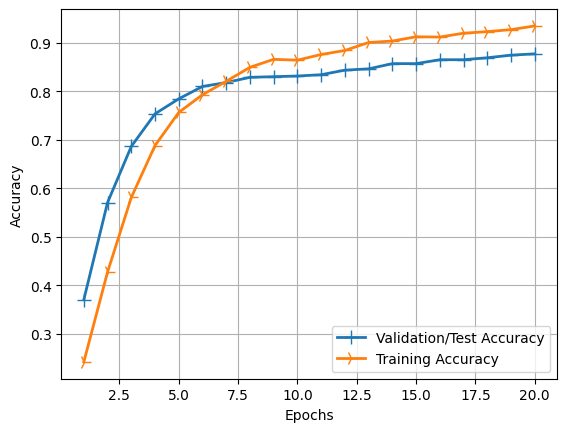

In [ ]:
# Plotting our accuracy charts
import matplotlib.pyplot as plt

history_dict = history.history

# Extract the accuracy and validation accuracy
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

# Get the number of epochs and create an array up to that number using range()
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label='Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label='Training Accuracy')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
x_test.shape

(743, 224, 224, 3)

In [ ]:
# Create calidation dataset
x_test = np.copy(images)
y_test = np.copy(labels)

x_test = np.array(x_test)
y_test = np.array(y_test)

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

x_test = x_test.reshape(743, 224, 224, 3)
y_pred = np.argmax(model.predict(x_test), axis=-1)

print(confusion_matrix(y_test, y_pred))

24/24 [==============================] - 4s 93ms/step
[[140   0   0   5   0   1   1]
 [  0  18   0  10   1   5   0]
 [  0   0  62   0   0   0   0]
 [  0   0   0 144   0   0   1]
 [ 12   1   0   8 137   1   2]
 [  0   3   0  35   0   5   0]
 [  2   0   0   2   1   0 146]]


In [ ]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

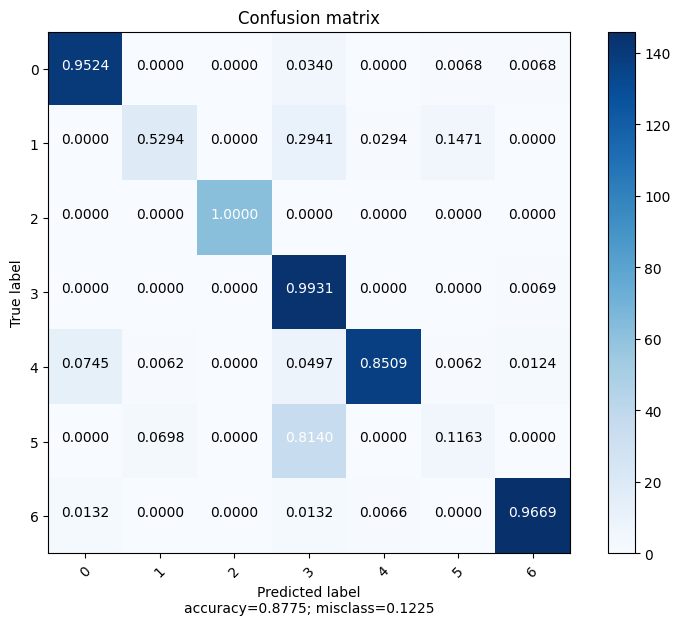

In [ ]:
target_names = list(range(0,7))
conf_mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat, target_names)

### **Let's look at our per-class accuracy**

In [ ]:
# Per-class accuracy
class_accuracy = 100 * conf_mat.diagonal() / conf_mat.sum(1)

for (i, classAccuracy) in enumerate(class_accuracy):
    print(f'Accuracy for {i} : {classAccuracy:.3f}%')

Accuracy for 0 : 95.238%
Accuracy for 1 : 52.941%
Accuracy for 2 : 100.000%
Accuracy for 3 : 99.310%
Accuracy for 4 : 85.093%
Accuracy for 5 : 11.628%
Accuracy for 6 : 96.689%


In [ ]:
num_of_images = 20
figure = plt.figure(figsize=(18,14))

for index in range(0, num_of_images):

  i = random.randint(0, 419)

  image = x_test[i]
  img = image.reshape(1, 224, 224, 3)
  label = labels_name[y_test[i]]
  prediction = labels_name[np.argmax(model.predict(img, verbose=0))]

  image = image / 255.0
  plt.subplot(4, 5, index +1).set_title(f"Actual: {label},\n Predicted: {prediction}")
  plt.axis('off')
  plt.imshow(image)


Output hidden; open in https://colab.research.google.com to view.

## **6. Saving and Loadng our Model**

In [ ]:
# Save modl in h5 format
model.save("Strawberry_Diseases_ResNet50_87.h5")

# Save model in pb format
model.save('/content/')

# Save model in Tensorflow lite format
print("Model Saved")

Model Saved


**Loading our Saved Model is also simple, just use:**

In [ ]:
# Import our load_model function
from tensorflow.keras.models import load_model

classifier = load_model('Strawberry_Diseases_ResNet50_87.h5')